Parsing of website, collecting data and preprocees it are in parsing.py

In [1]:
!python parsing.py

Parse all scripts from this website https://fangj.github.io/friends/
Total: 100% 228/228 [00:39<00:00,  5.81it/s]
Number of characters in dataframe 196
100% 6/6 [00:00<00:00,  9.65it/s]
script created


In [2]:
import pandas as pd
import nltk
import numpy as np
import os
import re  #regular expressions
from nltk.stem import wordnet  # for lemmtization
from sklearn.feature_extraction.text import CountVectorizer  # for bag of words (bow)
from sklearn.feature_extraction.text import TfidfVectorizer  #for tfidf
from nltk import pos_tag  # for parts of speech
from sklearn.metrics import pairwise_distances  # cosine similarity
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('omw-1.4')  #this is for the .apply() function to work
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Look at the stopwards from nltk library

In [3]:
for w in set(stopwords.words('english')):
  print(w, end=" | ")

up | doesn't | themselves | there | off | some | ain | yours | any | if | with | did | too | were | has | does | can | where | about | not | mustn | needn't | doing | once | they | all | below | herself | into | same | needn | you'll | couldn't | won | my | nor | this | through | didn | between | hers | yourself | s | wouldn | out | in | i | y | most | such | hasn | ourselves | under | for | o | by | she's | been | it's | further | couldn | ma | down | then | you're | didn't | me | than | these | here | until | she | be | because | haven't | why | while | won't | an | which | hadn't | had | he | own | no | are | at | of | theirs | t | having | aren't | against | weren | its | isn | it | don | we | her | again | don't | yourselves | wasn | mightn't | that | you'd | should | to | weren't | so | now | doesn | but | over | aren | ll | him | shan't | them | when | himself | how | only | being | during | whom | both | ours | or | have | hasn't | m | our | hadn | from | above | as | wouldn't 

### Check the data for any character

In [4]:
df = pd.read_csv("rachel_friends.csv")  # read the database into a data frame
# df = pd.read_csv("RickAndMortyScripts.csv")  # read the database into a data frame
df.head(10)  # see first 5 lines

questioner                                           question answerer  \
0       ross  hey uh mon, i saw the porsche parked out front...   rachel   
1       joey  saw the porsche out there mon, lookin’ good. w...   rachel   
2     monica  nice work everybody! so much for the y’know, y...   rachel   
3       ross                       whew! that was a brisk ride!   rachel   
4       ross                                   only way to fly.   rachel   
5       ross  you’re fast and irresponsible. that adds up to...   rachel   
6       ross  did you see the look that girl just gave me? h...   rachel   
7       ross                      what?!  give-give me a brush.   rachel   
8       ross                                            no way!   rachel   
9       ross  fine! y’know what? it doesn’t matter, because,...   rachel   

                                              answer  
0  wait a minute!  you let ross drive the porsche...  
1                            you let joey drive it?!  
2               wow! i can’t believe you lied to me.  
3                          take the top down did ya?  
4  come on ross give me the keys! monica does not...  
5  well in high school, that added up to head che...  
6      i think she’s checking out your beehive ross.  
7                                    gimme the keys!  
8                                     well no brush!  
9                                           alimony.

In [5]:
df.iloc[2]["question"], df.iloc[2]["answer"]

('nice work everybody! so much for the y’know, you can drive it, but don’t tell rachel plan!',
 'wow! i can’t believe you lied to me.')

In [6]:
# check for null values / empty cells
df.isnull().sum()

questioner    0
question      0
answerer      0
answer        0
dtype: int64

In [7]:
def text_normalization(text):
    text = str(text).lower()  # convert to all lower letters
    spl_char_text = re.sub(r'[^a-z]', ' ', text)  # remove any special characters including numbers
    tokens = nltk.word_tokenize(spl_char_text)  # tokenize words
    lema = wordnet.WordNetLemmatizer()  # lemmatizer initiation
    tags_list = pos_tag(tokens, tagset = None)  # parts of speech
    lema_words = []
    for token, pos_token in tags_list:
        if pos_token.startswith('V'):  # if the tag from tag_list is a verb, assign 'v' to it's pos_val
            pos_val = 'v'
        elif pos_token.startswith('J'):  # adjective
            pos_val = 'a'
        elif pos_token.startswith('R'):  # adverb
            pos_val = 'r'
        else:  # otherwise it must be a noun
            pos_val = 'n'
        lema_token = lema.lemmatize(token, pos_val)  # performing lemmatization
        lema_words.append(lema_token)  # addid the lemmatized words into our list
    return " ".join(lema_words)  # return our list as a human sentence

### Normalize questions

In [8]:
question_normalized = df['question'].apply(text_normalization)
df.insert(2, 'Normalized question', question_normalized, True)
df.head(), df.size

(  questioner                                           question  \
 0       ross  hey uh mon, i saw the porsche parked out front...   
 1       joey  saw the porsche out there mon, lookin’ good. w...   
 2     monica  nice work everybody! so much for the y’know, y...   
 3       ross                       whew! that was a brisk ride!   
 4       ross                                   only way to fly.   
 
                                  Normalized question answerer  \
 0  hey uh mon i saw the porsche park out front ca...   rachel   
 1  saw the porsche out there mon lookin good when...   rachel   
 2  nice work everybody so much for the y know you...   rachel   
 3                          whew that be a brisk ride   rachel   
 4                                    only way to fly   rachel   
 
                                               answer  
 0  wait a minute!  you let ross drive the porsche...  
 1                            you let joey drive it?!  
 2               wow! i 

### Define function which throw out stopwords from the questions

In [9]:
stop = stopwords.words('english') # Include stop words
stop = [] # Exclude stopwords
def removeStopWords(text):
  Q = []
  s = text.split()  # create an array of words from our text sentence, cut it into words
  q = ''
  for w in s:  # for every word in the given sentence if the word is a stop word ignore it
      if w in stop:
          continue
      else:  # otherwise add it to the end of our array
          Q.append(w)
      q = " ".join(Q)  # create a sentence out of our array of non stop words
  return q

### In this case i decided to leave stopwords, because they are very useful in common speech. For example in question "what are you doing?" stopwords throws out every word which leads to empty question

In [10]:
question_norm_and_stop = df['Normalized question'].apply(removeStopWords)
df.insert(3, 'Normalized and StopWords question', question_norm_and_stop, True)
df.head()

questioner                                           question  \
0       ross  hey uh mon, i saw the porsche parked out front...   
1       joey  saw the porsche out there mon, lookin’ good. w...   
2     monica  nice work everybody! so much for the y’know, y...   
3       ross                       whew! that was a brisk ride!   
4       ross                                   only way to fly.   

                                 Normalized question  \
0  hey uh mon i saw the porsche park out front ca...   
1  saw the porsche out there mon lookin good when...   
2  nice work everybody so much for the y know you...   
3                          whew that be a brisk ride   
4                                    only way to fly   

                   Normalized and StopWords question answerer  \
0  hey uh mon i saw the porsche park out front ca...   rachel   
1  saw the porsche out there mon lookin good when...   rachel   
2  nice work everybody so much for the y know you...   rachel   
3                          whew that be a brisk ride   rachel   
4                                    only way to fly   rachel   

                                              answer  
0  wait a minute!  you let ross drive the porsche...  
1                            you let joey drive it?!  
2               wow! i can’t believe you lied to me.  
3                          take the top down did ya?  
4  come on ross give me the keys! monica does not...

In [11]:
df_filtered = df[df['question'].apply(lambda x: len(x.split()) == 1)]
df_filtered

questioner   question Normalized question  \
31    policeman      nope.                nope   
32    policeman      nope.                nope   
33    policeman      nope.                nope   
34    policeman       yep.                 yep   
41         ross       who?                 who   
...         ...        ...                 ...   
8007     phoebe    where?!               where   
8040     monica  hormones.             hormone   
8042     phoebe        oh!                  oh   
8046     monica     what?!                what   
8055     monica      yeah.                yeah   

     Normalized and StopWords question answerer  \
31                                nope   rachel   
32                                nope   rachel   
33                                nope   rachel   
34                                 yep   rachel   
41                                 who   rachel   
...                                ...      ...   
8007                             where   rachel   
8040                           hormone   rachel   
8042                                oh   rachel   
8046                              what   rachel   
8055                              yeah   rachel   

                                                 answer  
31                                              taurus?  
32                                               virgo?  
33                                         sagittarius?  
34                          i knew it! i knew it, ahh….  
41                                        fourth gear!!  
...                                                 ...  
8007                                               hey!  
8040                                   …hormones, yeah.  
8042  it just might be too hard, given the history a...  
8046                           what?! she made the tea!  
8055  and y’know what else, oh my god, are they gonn...  

[999 rows x 6 columns]

In [12]:
import matplotlib.pyplot as plt

(array([3.554e+03, 2.050e+03, 1.083e+03, 5.920e+02, 3.420e+02, 1.810e+02,
        1.000e+02, 5.700e+01, 4.500e+01, 1.900e+01, 1.000e+01, 9.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([  0.  ,   6.05,  12.1 ,  18.15,  24.2 ,  30.25,  36.3 ,  42.35,
         48.4 ,  54.45,  60.5 ,  66.55,  72.6 ,  78.65,  84.7 ,  90.75,
         96.8 , 102.85, 108.9 , 114.95, 121.  ]),
 <BarContainer object of 20 artists>)

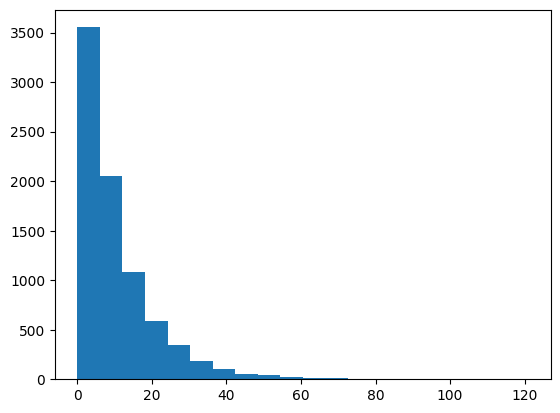

In [13]:
length_sentences = df["Normalized question"].apply(lambda x: len(x.split()))
plt.hist(length_sentences, bins=20)

## Initialize TF-IDF

In [14]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=5024)  # initializing tf-idf
x_tfidf = tfidf.fit_transform(df['Normalized and StopWords question']).toarray()  # oversimplifying this converts words to vectors

features_tfidf = tfidf.get_feature_names_out()  # use function to get all the normalized words
df_tfidf = pd.DataFrame(x_tfidf, columns = features_tfidf)  # create dataframe to show the 0, 1 value for each word
# df_tfidf.loc[:,['hello', 'rick', 'morty']].head()  # show only specific columns
df_tfidf.head()

able  able to  about  about be  about him  about how  about it  about me  \
0   0.0      0.0    0.0       0.0        0.0        0.0       0.0       0.0   
1   0.0      0.0    0.0       0.0        0.0        0.0       0.0       0.0   
2   0.0      0.0    0.0       0.0        0.0        0.0       0.0       0.0   
3   0.0      0.0    0.0       0.0        0.0        0.0       0.0       0.0   
4   0.0      0.0    0.0       0.0        0.0        0.0       0.0       0.0   

   about my  about ross  ...  youre have  youre not  youre not gon  \
0       0.0         0.0  ...         0.0        0.0            0.0   
1       0.0         0.0  ...         0.0        0.0            0.0   
2       0.0         0.0  ...         0.0        0.0            0.0   
3       0.0         0.0  ...         0.0        0.0            0.0   
4       0.0         0.0  ...         0.0        0.0            0.0   

   youre right  youre such  youre the  yours  yourself  youve  youve get  
0          0.0         0.0        0.0    0.0       0.0    0.0        0.0  
1          0.0         0.0        0.0    0.0       0.0    0.0        0.0  
2          0.0         0.0        0.0    0.0       0.0    0.0        0.0  
3          0.0         0.0        0.0    0.0       0.0    0.0        0.0  
4          0.0         0.0        0.0    0.0       0.0    0.0        0.0  

[5 rows x 5024 columns]

## Create tf-df function to find most relevant answers to the question

In [15]:
def chat_tfidf(question):
    tidy_question = text_normalization(removeStopWords(question))  # clean & lemmatize the question
    tf = tfidf.transform([tidy_question]).toarray()  # convert the question into a vector
    cos = 1- pairwise_distances(df_tfidf, tf, metric = 'cosine')  # calculate the cosine value
    index_value = cos.argmax()  # find the index of the maximum cosine value
    # answer = Answer("Ross", df['answer'].loc[index_value])
    answer = df['answer'].loc[index_value]
    return answer

In [16]:
# "what?! give-give me a brush."
print(chat_tfidf("what?! give-give me a brush."))

gimme the keys!


How to take in account context. I will do this with context vector.Length of context is 3 sentences. weight vector is [0.1, 0.5, 1]. 3rd sentence is our last message to the bot

In [17]:
def chat_tfidf_context(question, history):

  len_history = len(history)

  if len_history > 1:
    memory_weights = np.array([0.1, 0.3, 1.0]) # .reshape((3,1))
    # take last two sentences in accordance to bot's memory
    history = history[-2:]

  else:
    memory_weights = np.array([0.3, 1.0])

  history_sentence = np.zeros(shape=(len_history+1, 5024))

  for ind, h in enumerate(history):
    # normalize first question from context
    tidy_question = text_normalization(removeStopWords(h[0]))
    # pass via tfidf
    tf = tfidf.transform([tidy_question]).toarray()

    # assign tf idf vector to history sentence
    history_sentence[ind] = tf * memory_weights[ind]

  tidy_question = text_normalization(removeStopWords(question))
  tf = tfidf.transform([tidy_question]).toarray()

  history_sentence[-1] = tf
  history_sentence = history_sentence.mean(axis=0).reshape(1,-1)

  cos = 1- pairwise_distances(df_tfidf, history_sentence, metric = 'cosine')
  index_value = cos.argmax()
  answer = df['answer'].loc[index_value]

  return answer


### Check how it works

In [18]:
chat_tfidf_context(question="no way!", history=[["what?! give-give me a brush.", "gimme the keys!"]])

'well no brush!'

### you can use these question and answers to check the chatbot

In [19]:
print(df['question'].iloc[[14,75,23,94]])

14                               with you?! yeah right!
75                                             uh, hey!
23    no rach! come on! no-no! yeah, i’m sure we won...
94    you have no idea what a nightmare this has bee...
Name: question, dtype: object


In [20]:
print(df['answer'].iloc[[14,75,23,94]])

14                                           all right.
75                                      whats going on?
23           hi officer, was i going a little too fast?
94    oh yeah, really? is it ross? yeah? okay, well ...
Name: answer, dtype: object


### In this HW i don't use fasttext because of bad quality of vectorization

In [21]:
from string import punctuation
from tqdm.auto import tqdm, trange

In [22]:
punkt = [p for p in punctuation] + ["`", "``" ,"''", "'"]
for p in punkt:
  print(p, end=" | ")

! | " | # | $ | % | & | ' | ( | ) | * | + | , | - | . | / | : | ; | < | = | > | ? | @ | [ | \ | ] | ^ | _ | ` | { | | | } | ~ | ` | `` | '' | ' | 

In [23]:
def tokenize(sent: str) -> str:
  # text = str(sent).lower()  # convert to all lower letters
  tokens = nltk.word_tokenize(sent.lower())  # tokenize words
  return ' '.join([word for word in tokens if word not in stop and word not in punkt])

questions_preprocessed = []
for question in df["question"].tolist() + df["answer"].tolist():
  questions_preprocessed.append(tokenize(question))

In [24]:
questions_preprocessed[:10]

['hey uh mon i saw the porsche parked out front can i get the keys thought i ’ d take that bad boy out for a little spin',
 'saw the porsche out there mon lookin ’ good when do i get to take that baby out again',
 'nice work everybody so much for the y ’ know you can drive it but don ’ t tell rachel plan',
 'whew that was a brisk ride',
 'only way to fly',
 'you ’ re fast and irresponsible that adds up to a bad driver',
 'did you see the look that girl just gave me huh she must ’ ve seen me cruising in the bad boy',
 'what give-give me a brush',
 'no way',
 'fine y ’ know what it doesn ’ t matter because if i remember correctly there is a comb on the floor of the bathroom']

Обучим Word2vec на нашем корпусе текстов + добавим отдельный вектор для UNK, чтобы избежать вечной проблемы с поиском слов, которые отсутсвуют в тренировочной выборке.

In [25]:
questions_w2v = [sent.split(" ") for sent in questions_preprocessed]

In [26]:
%%time
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

CPU times: user 95.9 ms, sys: 19.6 ms, total: 115 ms
Wall time: 347 ms


In [27]:
# w2v = Word2Vec(sentences=questions_w2v, min_count=2, vector_size=50, window=6, seed=33, workers=4)
w2v = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [28]:
w2v.save('w2v.bin')

In [29]:
w2v = KeyedVectors.load('w2v.bin')

In [30]:
unknown_vector = np.random.uniform(low=-0.2, high=0.2, size=(25,))

### Define function which calculates vectorized sentences and for unknown words insert special vector

In [31]:
def w2v_get_vector_for_sentence(sentence):
  sent = nltk.word_tokenize(sentence.lower())
  sent = [word for word in sent if word not in punkt]
  sentence_vector = []
  if len(sent)==0:
    sentence_vector.append(unknown_vector)
  else:
    for word in sent:
      if word in w2v.key_to_index:
        sentence_vector.append(w2v[word])
      else:
        sentence_vector.append(unknown_vector)

  return np.array(sentence_vector).mean(axis=0)

### Calculate the base with vectorized sentences for dataframe

In [32]:
base = np.zeros(shape=(len(df.question), 25))
for ind, sentence in enumerate(df['question']):  #  df[df['question'].str.len() >= 1]
  base[ind] = w2v_get_vector_for_sentence(sentence)

In [33]:
def chat_word2vec(question):
  question = [w2v_get_vector_for_sentence(question)]
  cos = 1- pairwise_distances(base, question, metric = 'cosine')  # calculate the cosine value
  index_value = cos.argmax()  # find the index of the maximum cosine value
  answer = df['answer'].loc[index_value]
  return answer

In [34]:
def chat_word2vec_context(question, history):

  len_history = len(history)

  if len_history > 1:
    memory_weights = np.array([0.1, 0.3, 1.0]) # .reshape((3,1))
    # take last two sentences in accordance to bot's memory
    history = history[-2:]

  else:
    memory_weights = np.array([0.3, 1.0])

  history_sentence = np.zeros(shape=(len_history+1, 25))

  for ind, h in enumerate(history):
    sentence = w2v_get_vector_for_sentence(h[0])
    history_sentence[ind] = sentence * memory_weights[ind]

  question = w2v_get_vector_for_sentence(question)

  history_sentence[-1] = question
  history_sentence = history_sentence.mean(axis=0).reshape(1, -1)

  cos = 1- pairwise_distances(base, history_sentence, metric = 'cosine')
  index_value = cos.argmax()
  answer = df['answer'].loc[index_value]

  return answer

In [35]:
df.loc[2, ["question", "answer"]]

question    nice work everybody! so much for the y’know, y...
answer                   wow! i can’t believe you lied to me.
Name: 2, dtype: object

In [36]:
chat_word2vec_context(question="hey uh mon, i saw the porsche parked out front...", history=[])

'wait a minute!  you let ross drive the porsche and when i ask you, you say you’re the only one who’s allowed to drive it.'

In [37]:
chat_word2vec_context(question="saw the porsche out there mon, lookin’ good.", history=[["hey uh mon, i saw the porsche parked out front...", "wait a minute!  you let ross drive the porsche and when i ask you, you say you’re the only one who’s allowed to drive it."]])

'wait a minute!  you let ross drive the porsche and when i ask you, you say you’re the only one who’s allowed to drive it.'

Теперь перейдем к контекстуализированным эмбеддингам ваших документов/текстов с использованием предобученных Энкодерных текстовых моделей. Для решения более 90% задач этот метод отлично подходит как одно из первых решений и будет если не первым, то уж вторым точно baseline` решением.

Напомним, что BERT-like модели хороши тем, что помимо того, что они возвращают контекстуализированный эмбеддинг для каждого токена, у них еще есть представление всего текста, которое можно доставать из CLS токена (почти всегда он представлен на первом месте)

Для данной задачи используем *elastic/multilingual-e5-small-optimized*

### Load libraries, set device and download model with tokenizer

In [38]:
import torch
from transformers import AutoTokenizer, AutoModel

In [39]:
# model_name = "elastic/multilingual-e5-small-optimized"
model_name = "distilbert/distilbert-base-uncased"
device = "cpu"

In [40]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Define funcition to extract contextual embedding of full sentence

In [41]:
def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

### Define class for working with bert and dataframe

In [42]:
class BERTSearchEngine:
    def __init__(self, model, tokenizer, text_database):
        self.raw_procesed_data = [self.preprocess(sample, tokenizer) for sample in text_database]
        self.base = []
        self.retriever = None
        self.inverted_index = {}
        self._init_retriever(model, tokenizer, text_database)
        self._init_inverted_index(text_database)

    @staticmethod
    def preprocess(sentence: str, tokenizer):
        return tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    def _embed_bert_cls(self, tokenized_text: dict[torch.Tensor]) -> np.array:
        with torch.no_grad():
            model_output = self.retriever(**{k: v.to(self.retriever.device) for k, v in tokenized_text.items()})
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings[0].cpu().numpy()

    def _init_retriever(self, model, tokenizer, text_database):
        self.retriever = model
        self.tokenizer = tokenizer
        self.base = np.array([self._embed_bert_cls(self.preprocess(text, tokenizer)) for text in tqdm(text_database)])

    def retrieve(self, query: str) -> np.array:
        return self._embed_bert_cls(self.preprocess(query, self.tokenizer))

    def retrieve_documents(self, query: str, top_k=3) -> list[int]:
        query_vector = self.retrieve(query)
        cosine_similarities = cosine_similarity([query_vector], self.base).flatten()
        relevant_indices = np.argsort(cosine_similarities, axis=0)[::-1][:top_k]
        return relevant_indices.tolist()

    def _init_inverted_index(self, text_database: list[str]):
        self.inverted_index = dict(enumerate(text_database))

    def display_relevant_docs(self, query, full_database, top_k=3) -> list[int]:
        docs_indexes = self.retrieve_documents(query, top_k=top_k)
        return [self.inverted_index[ind] for ind in docs_indexes]

    def find_answer(self, query: str) -> int:
        query_vector = self.retrieve(query)
        cosine_similarities = cosine_similarity([query_vector], self.base).flatten()
        relevant_indice = np.argmax(cosine_similarities, axis=0)
        return relevant_indice


simple_search_engine = BERTSearchEngine(model, tokenizer, df['question'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/8058 [00:00<?, ?it/s]

### Save numpy array for faster loading

In [45]:
np.save("bert_base.npy", simple_search_engine.base)

### Load base to search_engine

In [ ]:
# simple_search_engine.base = np.load("bert_base.npy")

### Save data to local folder

In [ ]:
# model.save_pretrained('bert_model')
# tokenizer.save_pretrained('bert_tokenizer')

### Check most relevant sentence for  "How are you?"

In [44]:
query = 'How are you?'
simple_search_engine_results = simple_search_engine.display_relevant_docs(query, df['question'])
simple_search_engine_results

['how are you?', 'how are you?', 'how do you feel?']

In [ ]:
df.question[40], df.answer[40]

('when i was growing up i…played the one on the far left.',
 'remind me to introduce you to someone!')

### Define function for working with Bert retrival model and test it

In [ ]:
def chat_bert(question):
  ind = simple_search_engine.find_answer(question)
  answer = df['answer'].iloc[ind]
  return answer

In [ ]:
def chat_bert_context(question, history):

  len_history = len(history)

  if len_history > 1:
    memory_weights = np.array([0.1, 0.3, 1.0]) # .reshape((3,1))
    # take last two sentences in accordance to bot's memory
    history = history[-2:]

  else:
    memory_weights = np.array([0.3, 1.0])

  history_sentence = np.zeros(shape=(len_history+1, 384))

  for ind, h in enumerate(history):

    sentence = simple_search_engine.retrieve(h)
    history_sentence[ind] = sentence * memory_weights[ind]

  question = simple_search_engine.retrieve(question)

  history_sentence[-1] = question
  history_sentence = history_sentence.mean(axis=0).reshape(1, -1)

  cosine_similarities = cosine_similarity(history_sentence, simple_search_engine.base).flatten()
  relevant_indice = np.argmax(cosine_similarities, axis=0)
  answer = df['answer'].loc[relevant_indice]

  return answer

In [ ]:
chat_bert(question="rachel! what are you doing here?")

'i’m just visiting my good friend carol.'

In [ ]:
chat_word2vec_context(question="saw the porsche out there mon, lookin’ good.", history=[["hey uh mon, i saw the porsche parked out front...", "wait a minute!  you let ross drive the porsche and when i ask you, you say you’re the only one who’s allowed to drive it."]])

'wait a minute!  you let ross drive the porsche and when i ask you, you say you’re the only one who’s allowed to drive it.'

In [ ]:
chat_bert("rachel! what are you doing here?")

'i’m just visiting my good friend carol.'

## Install gradio for chatbot

In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account 

In [ ]:
import gradio as gr
import time

def echo(message, history, model):

  print(history)
  if model=="TF-IDF":
    # answer = chat_tfidf(message)
    answer = chat_tfidf_context(message, history)
    return answer

  elif model=="W2V":
    # answer = chat_word2vec(message)
    answer = chat_word2vec_context(message, history)
    return answer

  elif model=="BERT":
    answer = chat_bert_context(message, history)
    return answer




title = "Chatbot who speaks like Rachel from Friends"
description = "You have a good opportunity to have a dialog with friend's actor - Rachel Green"

# model = gr.CheckboxGroup(["TF-IDF", "W2V", "BERT", "BI-Encoder", "Cross-Encoder"], label="Model", info="What model do you want to use?", value="TF-IDF")
model = gr.Dropdown(["TF-IDF", "W2V", "BERT", "BI-Encoder", "Cross-Encoder"], label="Retrieval model", info="What model do you want to use?", value="TF-IDF")

with gr.Blocks() as demo:

    gr.ChatInterface(
        fn=echo,
        title=title,
        description=description,
        additional_inputs=[model],
        retry_btn=None,
        undo_btn=None,
        clear_btn=None,
    )

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://55ffad7ddcb9b39da4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


[]
[['hey', 'hi']]
[['hey', 'hi'], ['How are you?', 'ross!']]
[['hey', 'hi'], ['How are you?', 'ross!'], ['What?', 'no, you! phoebe you freaked me out. you kept saying how huge this all is!']]
[['hey', 'hi'], ['How are you?', 'ross!'], ['What?', 'no, you! phoebe you freaked me out. you kept saying how huge this all is!'], ['Do you want to play something with me?', 'well yeah, i wish that you would.  well, no it’s not in there!  how about that drawer?']]
[['hey', 'hi'], ['How are you?', 'ross!'], ['What?', 'no, you! phoebe you freaked me out. you kept saying how huge this all is!'], ['Do you want to play something with me?', 'well yeah, i wish that you would.  well, no it’s not in there!  how about that drawer?'], ['What do you think about children?', 'no paul, i don’t know anything about you! y’know, like-like your childhood! tell me about your childhood!']]
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://55ffad7ddcb9b39da4.gradio.live


In [ ]:
df[["question", "answer"]].head(10)

question  \
0  hey uh mon, i saw the porsche parked out front...   
1  saw the porsche out there mon, lookin’ good. w...   
2  nice work everybody! so much for the y’know, y...   
3                       whew! that was a brisk ride!   
4                                   only way to fly.   
5  you’re fast and irresponsible. that adds up to...   
6  did you see the look that girl just gave me? h...   
7                      what?!  give-give me a brush.   
8                                            no way!   
9  fine! y’know what? it doesn’t matter, because,...   

                                              answer  
0  wait a minute!  you let ross drive the porsche...  
1                            you let joey drive it?!  
2               wow! i can’t believe you lied to me.  
3                          take the top down did ya?  
4  come on ross give me the keys! monica does not...  
5  well in high school, that added up to head che...  
6      i think she’s checking out your beehive ross.  
7                                    gimme the keys!  
8                                     well no brush!  
9                                           alimony.

In [ ]:
import pandas as pd

# Example DataFrame
data = {
    "name_1": ["Alice", "Bob", "Charlie"],
    "sentence2": ["This is sentence 1", "This is sentence 2", "This is sentence 3"],
    "name_2": ["Dave", "Eve", "Frank"],
    "sentence_2": ["Another sentence 1", "Another sentence 2", "Another sentence 3"],
    "label": [0, 1, 0]
}
df = pd.DataFrame(data)

# Create a list of dictionaries
list_of_dicts = []
for index, row in df.iterrows():
    # Create a dictionary for the current row
    row_dict = {
        "name_1": row["name_1"],
        "sentence2": row["sentence2"],
        "name_2": row["name_2"],
        "sentence_2": row["sentence_2"],
        "label": row["label"]
    }
    # Append the dictionary to the list
    list_of_dicts.append(row_dict)

# Print the list of dictionaries
print(list_of_dicts)